# 0. Initialize

In [1]:
#@title Connect to gDrive & Load Files
ENV_COLAB = 'google.colab' in str(get_ipython())
if ENV_COLAB:
    print('Running on CoLab')
    PROJECT_DRIVE_FOLDER= "/content/drive/MyDrive/NiPAMS/BP development/analysis/nipams-bp-py-main/" #@param {"type":"string"}
    ## Load this for local development version of library.. Loads from GoogleDrive (changes persist)
    from google.colab import drive, widgets, data_table; 
    drive.mount('/content/drive');
    %cd "$PROJECT_DRIVE_FOLDER"
  
    !pip install -qr requirements.txt
    !pip install -q envyaml
    import os, sys; 
    from envyaml import EnvYAML; env = EnvYAML('env/default.yml'); 
    for k,v in env.export().items(): os.environ[k]=str(v)
    sys.path.append(os.path.abspath("./src"))

else:
    print('Not running on CoLab')
    %cd /app
!pwd

from importlib import reload;
from utils.constants import *

Running on CoLab
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main
     |████████████████████████████████| 210 kB 5.6 MB/s 
     |████████████████████████████████| 226 kB 33.0 MB/s 
     |████████████████████████████████| 9.6 MB 42.4 MB/s 
     |████████████████████████████████| 175 kB 79.5 MB/s 
     |████████████████████████████████| 357 kB 89.1 MB/s 
/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main


In [2]:
!pip install tsai -Uq
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

     |████████████████████████████████| 234 kB 4.3 MB/s 
     |████████████████████████████████| 188 kB 32.5 MB/s 
     |████████████████████████████████| 2.5 MB 53.3 MB/s 
     |████████████████████████████████| 60 kB 9.1 MB/s 
tsai       : 0.3.0
fastai     : 2.5.6
fastcore   : 1.4.2
torch      : 1.10.0+cu111


In [3]:
from data import load_data, preprocess; reload(load_data);reload(preprocess)
from models import experiments; reload(experiments)

<module 'models.experiments' from '/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main/src/models/experiments.py'>

# Load & Process Data

In [4]:
# dfAll = load_data.load_dataframe_from_pickle(folder='data/interim/', pattern='HLV_lg')
# dfAll
# dfImuCont, dfBpCont = load_data.load_dataframe_from_mat(PROJECT_DRIVE_FOLDER+'data/data_cleaned_LVET',".*sub.*/.*"+"LLV"+".*.mat", limit_files=10)

In [5]:
dfBpCont, dfImuCont = load_data.load_dataframe_from_mat(folder='data/data_cleaned_LVET', pattern=f'{"LLV"}\d+.mat', limit_files=100)
dfAll = preprocess.merge_imu_vcg_with_heartbeats(dfBpAll=dfBpCont, dfImuAll=dfImuCont)

sub252_LLV3.mat
Error with file None 0
sub337_LLV1.mat
Error with file None 0


In [6]:
dfImu = dfAll[INDICIES + IMU_DATA_COLS + ['ts']].reset_index(drop=True)
dfBp = dfAll[INDICIES + BP_COLS + ['ts']].reset_index(drop=True)

dfImu.update(dfImu.groupby('file', sort=False)[IMU_DATA_COLS].transform(lambda x : (x-x.mean())/x.std()))
dfImuSamp, dfBpSamp = preprocess.interpolateDatasets(dfImu.set_index('ts'), dfBpCont.set_index('ts'))
# dfImuSamp, dfBpSamp = dfImuSamp.reset_index().set_index('ts'), dfBpSamp.reset_index().set_index('ts')
#@title Merge IMU and BP Datasets by TimeStamp
# https://stackoverflow.com/questions/38833362/merge-dataframes-on-nearest-datetime-timestamp
def reindex_imu(inds, df, dfRef):
  return df.reset_index().set_index(['ts']).reindex(dfRef.loc[inds].reset_index().set_index(['ts']).index, method='nearest')

dfImuSampReind = dfImuSamp.reset_index().set_index(['file','ts'])
arrdfs = []
for inds, df in dfBpSamp.reset_index('file',drop=True).groupby('file'):
  try :
    dfReind = reindex_imu(inds, df, dfImuSampReind)
    arrdfs.append(dfReind.reset_index())
  except KeyError as e: 
    print("Failed to Process file : ", inds, str(e))


dfBpSampReind = pd.concat(arrdfs)
# dfReind = pd.merge(dfBpSampReind, dfImuSamp, on=['file','ts'])
dfReind = pd.merge(dfBpSampReind, dfImuSamp, on=['file','ts'], suffixes=('','_drop'))
dfReind = dfReind.drop(columns=dfReind.columns[dfReind.columns.str.contains('_drop')])

dfImu = dfReind[['ts'] + INDICIES + IMU_DATA_COLS].reset_index(drop=True)
dfBp = dfReind[['ts'] + INDICIES + BP_COLS].reset_index(drop=True)

Failed to Process file :  sub252_LLV3.mat 'sub252_LLV3.mat'
Failed to Process file :  sub337_LLV1.mat 'sub337_LLV1.mat'


# Manual Train & Test for Neural Network

## Setup Splits & ML Model

In [7]:
from tsai.data.preparation import SlidingWindowPanelSplitter

arrX = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
arrY = ['sbp']
dfReind[arrX + arrY] = dfReind[arrX + arrY].fillna(method='ffill').fillna(method='bfill')
# https://timeseriesai.github.io/tsai//data.preparation#SlidingWindowPanel
# X, y = SlidingWindowPanel(600, unique_id_cols=['file'], stride=200, 
X, y = SlidingWindowPanelSplitter(100, unique_id_cols=['file'], stride=500, 
                                  get_x=arrX,
                                  get_y=['sbp'])(dfReind)

splits_tsai = TrainValidTestSplitter(valid_size=0.2, shuffle=True)(y)

# Normalize y's
y_raw = y.copy()
y = (y - y.mean()) / y.std()

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


In [8]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X, y, splits=splits_tsai, tfms=tfms, batch_tfms=batch_tfms, bs=5)
# dls = get_ts_dls(X, y, tfms=tfms, batch_tfms=batch_tfms, bs=5)

X.shape, y.shape

((1318, 6, 100), (1318,))

## Build Model & Train

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.221087,1.439584,0.898872,1.199827,00:25
1,1.106482,1.531541,0.930881,1.237555,00:17
2,1.140891,1.349953,0.882006,1.161875,00:18
3,1.088011,1.277843,0.863150,1.130417,00:18
4,0.908715,1.150982,0.818939,1.072838,00:18
5,0.902128,1.042476,0.780048,1.021017,00:17
6,0.870951,0.991369,0.757796,0.995675,00:17
7,0.855937,0.884869,0.715298,0.940675,00:17
8,0.783228,0.806352,0.679133,0.897971,00:17
9,0.667734,0.800729,0.689963,0.894834,00:17


/usr/local/lib/python3.7/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)


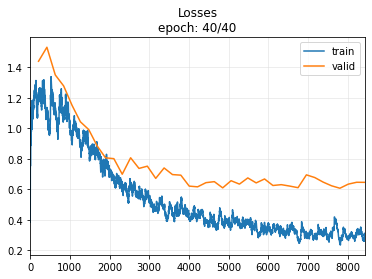

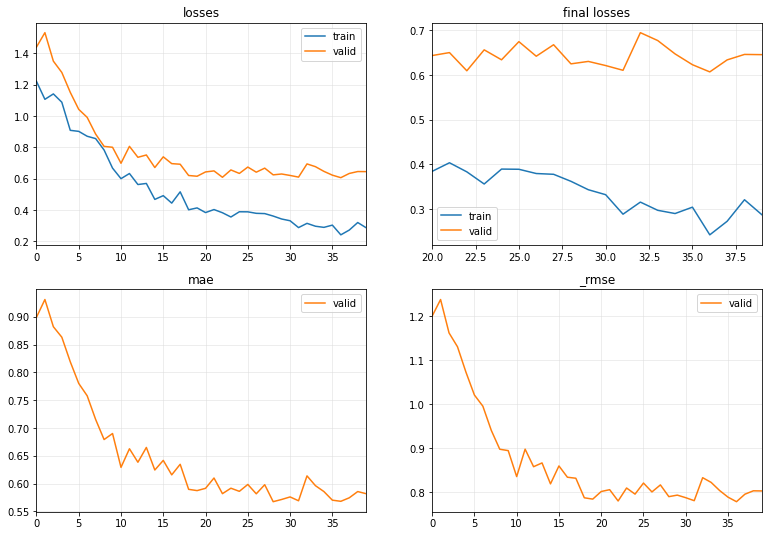

In [9]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(40, 1e-5)

In [13]:
def unnorm_y(ser): return (ser*y_raw.std()+y_raw.mean())

probas, _, preds = learn.get_X_preds(X[splits_tsai[1]])
yTarget, yPreds = unnorm_y(y[splits_tsai[1]]), unnorm_y(np.array(preds).flatten())

/usr/local/lib/python3.7/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)


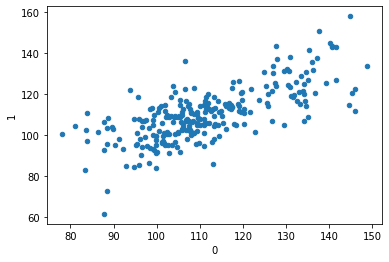

In [17]:
pd.DataFrame([yTarget, yPreds]).T.plot.scatter(0,1)

In [10]:
STOP_HERE

NameError: ignored

# Sklearn Pipeline

## Wrap Model as Sklearn Pipeline

In [ ]:
from sklearn.base import BaseEstimator

# https://scikit-learn.org/stable/developers/develop.html
class TSAI_InceptionTime(BaseEstimator):
  def __init__(self, target='sbp'):
    self.target = target

  def setup_dls(self, X, y):
    tfms  = [None, [TSRegression()]]
    batch_tfms = TSStandardize(by_var=True)
    splits = TrainValidTestSplitter(valid_size=0.2, shuffle=True)(y)

    dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=20)
    return dls


  def fit(self, X, y):
    print('TSAI.fit X', X.dtype, X.shape)
    print('TSAI.fit y', y.dtype, y.shape)
    
    X = X[:,1:,:].astype(np.float32)
    y = y.values
    
    print('TSAI.fit X', X.dtype, X.shape)
    print('TSAI.fit y', y.dtype, y.shape)
    self.y_train = y
    y = (y - y.mean()) / y.std()

    self.dls = self.setup_dls(X, y)
    
    self.learn = ts_learner(self.dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
    self.learn.fit_one_cycle(10, 1e-3)

    return self

  def predict(self, X):
    # X = X[:,:,1:].astype(np.float32)
    X = X[:,1:,:].astype(np.float32)
    
    probas, _, preds = self.learn.get_X_preds(X)
    yPreds = self.unnorm_y(np.array(preds).flatten())
    return np.array(yPreds).clip(40,180)
    

  def unnorm_y(self, ser):
    return (ser*self.y_train.std()+self.y_train.mean())

  ## TODO : proper scoring method
  ## TODO : also this breaks the mvd method somehow?
  def score(self, rows, y):
    # return 1
    return np.abs((self.predict(rows))-y).fillna(0).mean()

## Get Splits for Experiment

In [ ]:
reload(experiments)
# splits = experiments.split_by_random(dfImu, dfBp)
# splits = experiments.split_by_group('file', dfImu, dfBp)

splits = experiments.split_by_query(trainQ='heartbeat < 30', testQ='heartbeat > 30', dfImu=dfImu, dfBp=dfBp, )
# objExperimentDfs = experiments.get_experiment(splits[0], dfImu, dfBp)
# objExperimentDfs['train_y'].groupby(INDICIES, sort=False)['sbp'].mean()
# objExperimentDfs['train_x'].drop(, errors='ignore')

## Train & Test TSAI Pipeline

In [ ]:
reload(experiments); reload(preprocess)
from models import baselines
import sklearn.pipeline
tsExplodeTransform = preprocess.FunctionTransformer(partial(preprocess.explode_3d, data_cols=IMU_DATA_COLS))
tsReshape = preprocess.FunctionTransformer(lambda x : x.transpose(0,2,1))
# pipe = sklearn.pipeline.Pipeline([('transform', tsExplodeTransform), ('model', baselines.DummyRegressor())])
pipe = sklearn.pipeline.Pipeline([('transform', tsExplodeTransform),('transform-reshape', tsReshape), ('model', TSAI_InceptionTime())])

rfResults = experiments.testPipeline(dfImu, dfBp, pipe, splits, targetCol='sbp', verbose=True)
dfResults = experiments.resultsToDf(rfResults)
dfResults.plot.scatter('sbp','preds', title='Random Forest Model')